In [14]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

import math

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 3 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
size of X: (60000, 784)
size of Y: (60000, 10)


# Beta random selection (K=3, T=4)

43 11 10 4 32


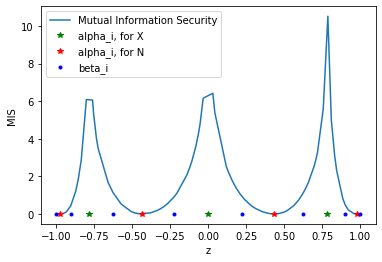

[ 7.818e-01  6.123e-17 -7.818e-01]
[ 0.975  0.434 -0.434 -0.975]
[ 9.749e-01  7.818e-01  4.339e-01  6.123e-17 -4.339e-01 -7.818e-01
 -9.749e-01 -9.749e-01]


In [54]:
K = 3
T = 4
Noise_Alloc = [0,2,4,6]
sigma = 1

N = 8

j_array = np.array(range(K+T+1))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 100
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    

print(alpha_array[Signal_Alloc])
print(alpha_array[Noise_Alloc])
print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [20]:
sigma = 1

z_array_sel = z_array_0
X_tilde_s0,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)

z_array_sel = z_array_1
X_tilde_s1,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)

z_array_sel = z_array_2
X_tilde_s2,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)

z_array_sel = z_array_3
X_tilde_s3,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)

z_array_sel = z_array_4
X_tilde_s4,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)

@BACC_Enc: N,K,T, m_i= 40 3 4 20000 

@BACC_Enc: N,K,T, m_i= 12 3 4 20000 

@BACC_Enc: N,K,T, m_i= 11 3 4 20000 

@BACC_Enc: N,K,T, m_i= 8 3 4 20000 

@BACC_Enc: N,K,T, m_i= 29 3 4 20000 



<Figure size 432x288 with 0 Axes>

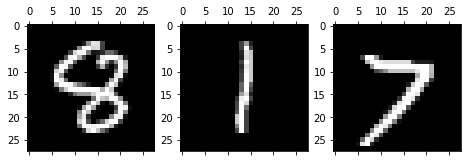

In [21]:
index_num = 3

index_sel = np.array(range(K))*Size_submatrices + index_num

input_images = encoding_input_array_np[index_sel,:]
input_labels = encoding_label_array_np[index_sel,:]

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,K):
    ax = fig.add_subplot(1,6,i+1)
    pixels = input_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

Encoded images B<0.5


<Figure size 432x288 with 0 Axes>

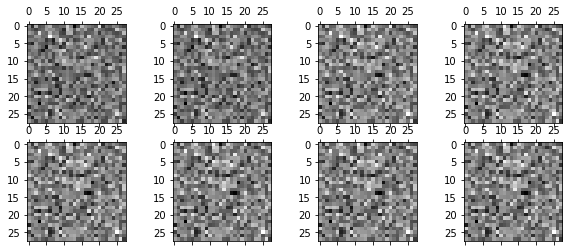

Encoded images 0.5<B<1


<Figure size 432x288 with 0 Axes>

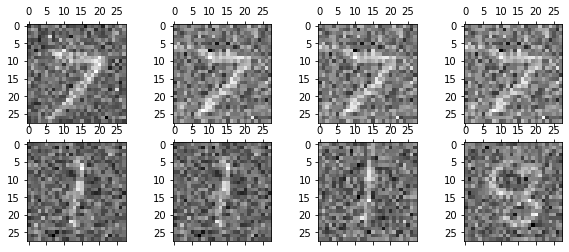

Encoded images 1<B<1.5


<Figure size 432x288 with 0 Axes>

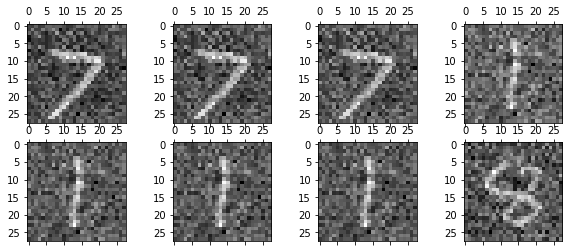

In [31]:


print("Encoded images B<0.5")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s0[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i+12,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

print("Encoded images 0.5<B<1")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s1[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

print("Encoded images 1<B<1.5")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s2[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()



Encoded images 1.5<B<2


<Figure size 432x288 with 0 Axes>

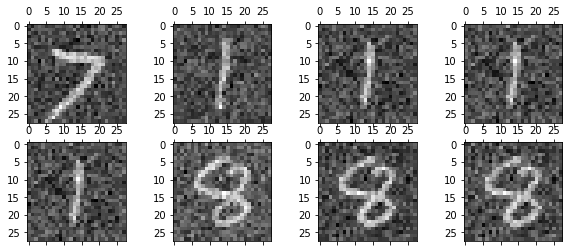

Encoded images B>2


<Figure size 432x288 with 0 Axes>

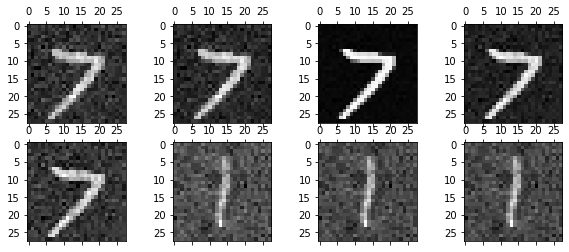

In [27]:
print("Encoded images 1.5<B<2")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s3[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

print("Encoded images B>2")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s4[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

In [70]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 3
T = 4
sigma = 1
Noise_Alloc = [0,2,4,6]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [8,  12]
B_array = [0.5, 1, 2]

N_trials = 1
N_epochs = 30



loss_test_arr_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
        while(len(z_array)<N):
            z_tmp = np.random.uniform(-1,1,1)
            MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
            if MIS_tmp < B and MIS_tmp > 0.1:
                z_array.append(z_tmp[0])
        
        z_array = np.sort(z_array)
        print('z_array:',z_array)
        
        sigma = 1 #sigma_array[sigma_idx]
        
        _Noise_label = np.ones((20000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [-0.932 -0.915 -0.566 -0.534 -0.318  0.28   0.505  0.514]
@BACC_Enc: N,K,T, m_i= 8 3 4 20000 

@BACC_Enc: N,K,T, m_i= 8 3 4 20000 

(T, sigma)= 4 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.2966 
Accuracy: 2083/10000 (20.83%)

Round   0, Average loss 2.297 Test accuracy 20.830
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3007 
Accuracy: 1025/10000 (10.25%)

Round   1, Average loss 2.301 Test accuracy 10.250
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.2557 
Accuracy: 3681/10000 (36.81%)

Round   2, Average loss 2.256 Test accuracy 36.810
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.1135 
Accuracy: 2387/10000 (23.87%)

Round   3, Average loss 2.113 Test accuracy 23.870
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.0753 
Accuracy: 4234/10000 (42.34%)

Round   4, Average loss 2.075 Test accuracy 42.340
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8337 
Accuracy: 7894


Test set: Average loss: 2.2877 
Accuracy: 1320/10000 (13.20%)

Round  23, Average loss 2.288 Test accuracy 13.200
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.2716 
Accuracy: 2932/10000 (29.32%)

Round  24, Average loss 2.272 Test accuracy 29.320
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.2793 
Accuracy: 3029/10000 (30.29%)

Round  25, Average loss 2.279 Test accuracy 30.290
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.2853 
Accuracy: 3009/10000 (30.09%)

Round  26, Average loss 2.285 Test accuracy 30.090
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.2045 
Accuracy: 4095/10000 (40.95%)

Round  27, Average loss 2.205 Test accuracy 40.950
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.2395 
Accuracy: 4029/10000 (40.29%)

Round  28, Average loss 2.239 Test accuracy 40.290
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.1680 
Accuracy: 7481/10000 (74.81%)

Round  29, Average loss 2.168 Test accurac


Test set: Average loss: 2.1326 
Accuracy: 5043/10000 (50.43%)

Round  14, Average loss 2.133 Test accuracy 50.430
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Test set: Average loss: 2.2856 
Accuracy: 2178/10000 (21.78%)

Round  15, Average loss 2.286 Test accuracy 21.780
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Test set: Average loss: 2.0963 
Accuracy: 7057/10000 (70.57%)

Round  16, Average loss 2.096 Test accuracy 70.570
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Test set: Average loss: 2.1436 
Accuracy: 4940/10000 (49.40%)

Round  17, Average loss 2.144 Test accuracy 49.400
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Test set: Average loss: 2.1694 
Accuracy: 6764/10000 (67.64%)

Round  18, Average loss 2.169 Test accuracy 67.640
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Test set: Average loss: 2.1750 
Accuracy: 4114/10000 (41.14%)

Round  19, Average loss 2.175 Test accuracy 41.140
selected users: [ 0  1  2  3  4  5  6  7


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Test set: Average loss: 2.2852 
Accuracy: 2785/10000 (27.85%)

Round   2, Average loss 2.285 Test accuracy 27.850
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Test set: Average loss: 2.2897 
Accuracy: 2179/10000 (21.79%)

Round   3, Average loss 2.290 Test accuracy 21.790
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Test set: Average loss: 2.2219 
Accuracy: 6169/10000 (61.69%)

Round   4, Average loss 2.222 Test accuracy 61.690
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Test set: Average loss: 2.2573 
Accuracy: 3161/10000 (31.61%)

Round   5, Average loss 2.257 Test accuracy 31.610
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Test set: Average loss: 2.2446 
Accuracy: 2179/10000 (21.79%)

Round   6, Average loss 2.245 Test accuracy 21.790
selected users: [ 0  1  2  3  4  5  6  7  8

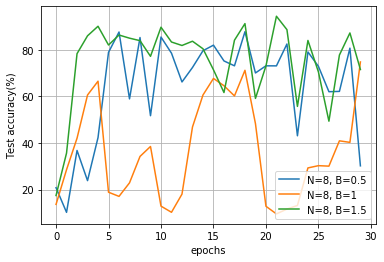

In [71]:
plt.plot(acc_test_arr_v1[0,0,0,0:30],label='N=8, B=0.5')
plt.plot(acc_test_arr_v1[0,1,0,0:30],label='N=8, B=1')
plt.plot(acc_test_arr_v1[0,2,0,0:30],label='N=8, B=1.5')
# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

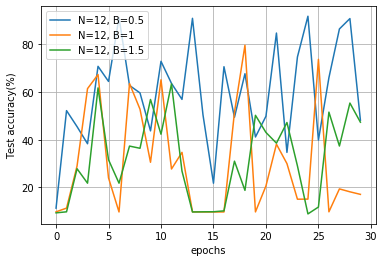

In [72]:
plt.plot(acc_test_arr_v1[1,0,0,0:30],label='N=12, B=0.5')
plt.plot(acc_test_arr_v1[1,1,0,0:30],label='N=12, B=1')
plt.plot(acc_test_arr_v1[1,2,0,0:30],label='N=12, B=1.5')
# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()